In [ ]:
import pandas as pd
import random
import torch
from pandas import read_excel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
import tensorflow as tf
from sklearn.utils import class_weight
from google.colab import drive

In [ ]:
import pickle
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Mounted at /content/gdrive


''

In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/"

In [ ]:
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

seed_everything(42)

Random seed set as 42


# **Extra Preprocessing**

---



In [ ]:
df = pd.read_csv(location + "clinical_masterDB.csv", sep=",")
df.head(5)

,PATNO,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,GENDER,ENROLLDT,AGE,HISPLAT,RAINDALS,...,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,3000.0,5.0,0.0,12.0,0.0,0,02/2011,69,0.0,0.0,...,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,0
1,3001.0,6.0,0.0,15.5,0.0,1,03/2011,65,0.0,0.0,...,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,1
2,3002.0,6.0,0.0,16.0,0.0,0,03/2011,67,0.0,0.0,...,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,1
3,3003.0,4.0,0.0,6.0,0.0,0,04/2011,56,0.0,0.0,...,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,1
4,3004.0,5.0,0.0,8.0,0.0,1,04/2011,59,0.0,0.0,...,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,0


In [ ]:
print(len(df.columns))

50


1.   Converted **SLEEPINESS, DEPRESSION, RBD_STATUS** into binary and checked correlations: They are not necessary hence remove
2.   Remove **PATNO, ENROLLDT, RAHAWOPI (only value present is 0)**
3. Binary Variables: **GENDER, HISPLAT, RAINDALS, RAASIAN, RABLACK, RAWHITE, RANOS**







In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/Clinical/"

# **XGBoost Feature Selection**

---

In [ ]:
df = df.drop(columns = ["PATNO", "ENROLLDT", "RAHAWOPI", "SLEEPINESS", "DEPRESSION", "RBD_STATUS", "GENDER", "HISPLAT"
                        ,"RAINDALS", "RAASIAN", "RABLACK", "RAWHITE", "RANOS",
                        "MDS_UPDRS1", "MDS_UPDRS2", "MDS_UPDRS3",
                        # "SCOPA_TOTAL", "SCOPA_GASTRO", "SCOPA_URINARY", "SCOPA_CARDIO", "SCOPA_THERMO", "SCOPA_PUPIL", "SCOPA_SEXUAL",
                        # "First_Fam_Num", "First_Fam_PD", "Other_Fam_Num", "Other_Fam_PD", "AGE",
                        # "Socio_Score",
                        "MOCA","Unadjusted_MOCA",
                        # "BJLO",	"ESS", "GDS", "HVLT_RECALL", "HVLT_RECOG", "HVLT_RETENT", "LNS", "QUIP_SEC_A", "QUIP_SEC_B", "QUIP_SEC_C", "QUIP_SEC_D",	"QUIP_SEC_E",
                        # "RBDSQ", "SFT", "STAI",
                        # "UPSIT",
                        "TREMOR", "PIGD"
                        ], axis = 1)
df.head()

,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,HVLT_RECALL,...,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,28.125,...,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,0
1,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,26.875,...,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,1
2,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,25.875,...,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,1
3,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,26.125,...,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,1
4,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,21.000,...,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,0


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,HVLT_RECALL,...,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,8.0,0.0,18.0,0.0,64,12.0,9.000000,3.285714,0.571429,19.142857,...,2.142857,4.428571,0.000000,0.571429,0.428571,0.000000,39.000000,49.428571,31.0,0
1,8.0,0.0,14.0,0.0,69,17.0,13.571429,4.750000,0.500000,23.428571,...,2.250000,4.125000,0.000000,0.750000,0.000000,0.750000,48.285714,50.250000,18.0,1
2,14.0,2.0,9.0,1.0,51,12.0,12.200000,3.666667,2.666667,16.200000,...,2.166667,4.500000,0.333333,1.000000,0.000000,1.500000,36.000000,58.833333,15.0,1
3,6.0,0.0,13.0,0.0,54,16.0,12.000000,0.285714,0.000000,26.166667,...,0.571429,3.000000,0.428571,2.285714,0.000000,1.142857,62.833333,47.714286,36.0,1
4,8.0,0.0,10.0,0.0,44,20.0,11.600000,12.500000,3.000000,33.800000,...,4.666667,4.500000,1.500000,4.333333,1.166667,0.333333,53.600000,78.166667,33.0,1


In [ ]:
print(len(df))

input_columns=len(df.columns)-1
output_columns=1

X = df.iloc[:, 0:input_columns]
y = df.iloc[:, -1]

682


27
UPSIT            0.167698
First_Fam_PD     0.134494
SCOPA_GASTRO     0.119174
SCOPA_TOTAL      0.066630
Other_Fam_PD     0.063303
RBDSQ            0.036642
SCOPA_CARDIO     0.035928
AGE              0.035910
SCOPA_THERMO     0.034162
LNS              0.027357
STAI             0.027018
SCOPA_PUPIL      0.024693
QUIP_SEC_B       0.020441
HVLT_RECOG       0.020192
First_Fam_Num    0.019736
SFT              0.018999
HVLT_RECALL      0.017706
QUIP_SEC_D       0.015492
ESS              0.015238
HVLT_RETENT      0.015146
GDS              0.014511
Other_Fam_Num    0.014397
SCOPA_SEXUAL     0.013193
BJLO             0.012699
Socio_Score      0.011063
SCOPA_URINARY    0.009165
QUIP_SEC_E       0.009013
dtype: float32


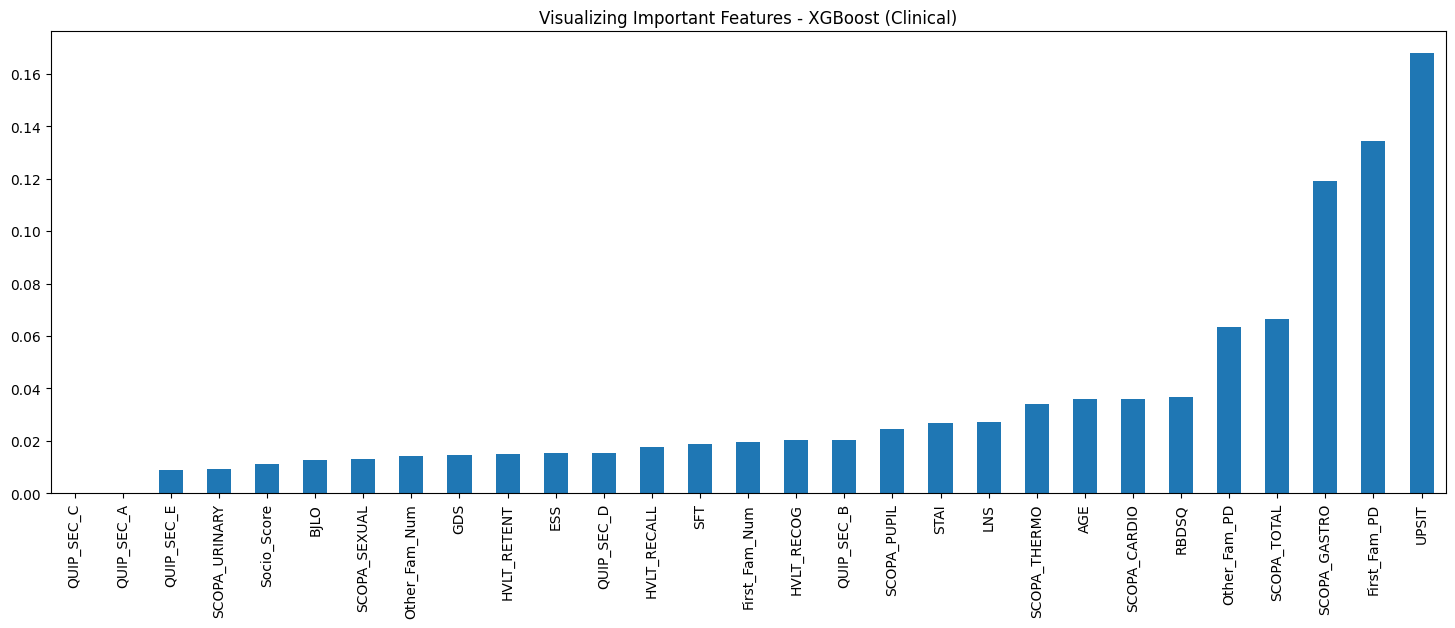

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X, y)

feature_imp = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(len(feature_imp[feature_imp>0]))
print(feature_imp[feature_imp>0])

feature_imp.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))
plt.title("Visualizing Important Features - XGBoost (Clinical)")
plt.show()

feaSel_xgb = list(feature_imp[feature_imp>0].index)

In [ ]:
file = location + "feaSel_xgb_Clin.txt"
with open(file, 'w') as file:
        for row in feaSel_xgb:
            s = "".join(map(str, row))
            file.write(s+'\n')

# **ML Models**

---



In [ ]:
print(len(df.columns))
print(df.columns)

30
Index(['First_Fam_Num', 'First_Fam_PD', 'Other_Fam_Num', 'Other_Fam_PD', 'AGE',
       'Socio_Score', 'BJLO', 'ESS', 'GDS', 'HVLT_RECALL', 'HVLT_RECOG',
       'HVLT_RETENT', 'LNS', 'QUIP_SEC_A', 'QUIP_SEC_B', 'QUIP_SEC_C',
       'QUIP_SEC_D', 'QUIP_SEC_E', 'RBDSQ', 'SCOPA_TOTAL', 'SCOPA_GASTRO',
       'SCOPA_URINARY', 'SCOPA_CARDIO', 'SCOPA_THERMO', 'SCOPA_PUPIL',
       'SCOPA_SEXUAL', 'SFT', 'STAI', 'UPSIT', 'STATUS'],
      dtype='object')


In [ ]:
print(len(df))
# print(train_length, val_length)

input_columns=len(df.columns)-1
output_columns=1

682


In [ ]:
train_length = int(0.8*len(df))
test_length = int(0.2*len(df))+1
print(train_length, test_length)

545 137


In [ ]:
# dataset = df.values
X = df.iloc[:train_length,0:input_columns]
y = df.iloc[:train_length, -1]

X_test = df.iloc[train_length: (train_length + test_length), 0:input_columns]
y_test = df.iloc[train_length: (train_length + test_length), -1]

In [ ]:
train_data_file = location + 'train_data.pkl'
test_data_file = location + 'test_data.pkl'

# Save training data
with open(train_data_file, 'wb') as f:
    pickle.dump((X, y), f)

# Save test data
with open(test_data_file, 'wb') as f:
    pickle.dump((X_test, y_test), f)

Train Data distribtuion:
STATUS
PD    389
HC    156
Name: count, dtype: int64


<Axes: title={'center': 'Train Data class histogram'}, xlabel='STATUS', ylabel='Frequency'>

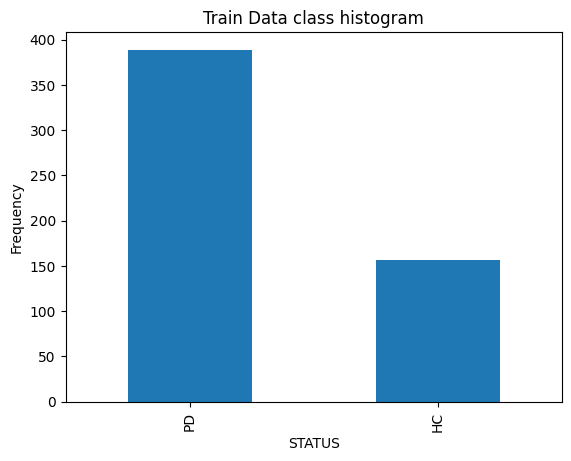

In [ ]:
# Train data distribution
count_classes = y.replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
count_classes.plot(kind = 'bar')

Test Data distribtuion:
STATUS
PD    97
HC    40
Name: count, dtype: int64


<Axes: title={'center': 'Test Data class histogram'}, xlabel='STATUS', ylabel='Frequency'>

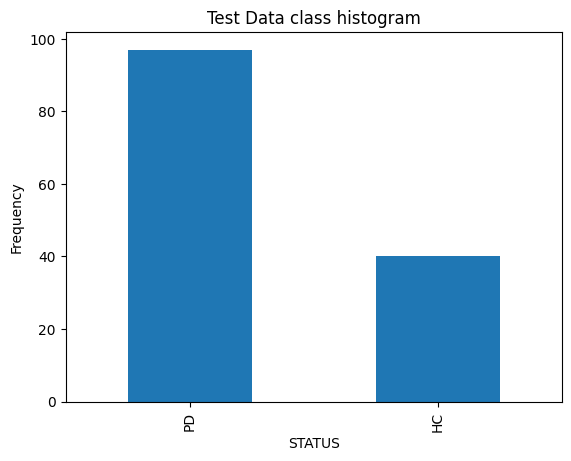

In [ ]:
# Test data distribution
count_classes = y_test.replace({0:"HC", 1:"PD"}).value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
count_classes.plot(kind = 'bar')

In [ ]:
scalarX = MinMaxScaler() # Normalising
scalarX.fit(X)

X = scalarX.transform(X)
X_test = scalarX.transform(X_test)

## **Random Forest**

---

In [ ]:
clf = RandomForestClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

#Setting the range for class weights
weights = np.linspace(0.5,0.99,50)


# specify parameters and distributions to sample from
hp = {'bootstrap': [True, False],
      'criterion': ['gini', 'entropy'],
      'n_estimators': [10, 25],
      'max_features': [5, 10],
      'max_depth': [10, 50, None],
      'max_depth': np.arange(5, 10, 1),
      'max_features': [5, 6, 7],
      'min_samples_leaf': [0, 1, 2, 3, 4, 5],
      'min_samples_split': [1, 2, 5, 10],
      'n_estimators': np.arange(10, 500, 10),
      'warm_start': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 250
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'clin_RF' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
410 fits failed out of a total of 1250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

RandomForestClassifier(bootstrap=False,
                       class_weight={0: 0.8, 1: 0.19999999999999996},
                       criterion='entropy', max_depth=6, max_features=7,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=350)
{'bootstrap': False,
 'class_weight': {0: 0.8, 1: 0.19999999999999996},
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 350,
 'warm_start': False}

Saving model



AUC-ROC =  0.922680412371134
AUC-PR =  0.964676100932035
F1 score =  0.8972972972972973
Precision =  0.9431818181818182
Recall =  0.8556701030927835
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        40
           1       0.94      0.86      0.90        97

    accuracy                           0.86       137
   macro avg       0.83      0.87      0.84       137
weighted avg       0.88      0.86      0.86       137



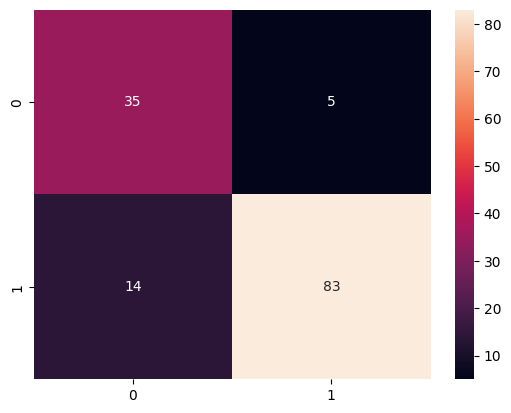

In [ ]:
# load the model from disk
filename = location + 'clin_RF' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_rf = clf


y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

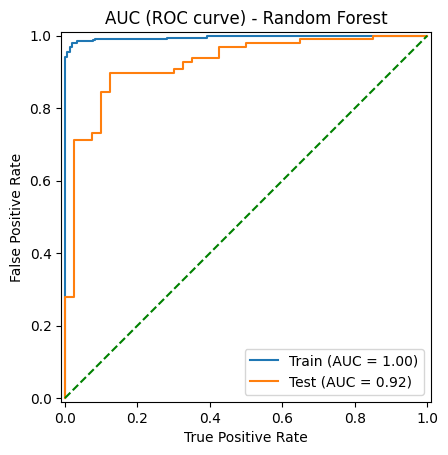

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    RocCurveDisplay.from_estimator(clf, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Random Forest")
plt.show()

## **Gaussian Naive Bayes**

---

In [ ]:
clf = GaussianNB()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'var_smoothing': np.logspace(0,-9, num=50)}
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'clin_GNB' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 50 is smaller than n_iter=200. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


GaussianNB(var_smoothing=0.03393221771895328)
{'var_smoothing': 0.03393221771895328}

Saving model



AUC-ROC =  0.9015463917525773
AUC-PR =  0.959162098680592
F1 score =  0.8070175438596491
Precision =  0.9324324324324325
Recall =  0.711340206185567
              precision    recall  f1-score   support

           0       0.56      0.88      0.68        40
           1       0.93      0.71      0.81        97

    accuracy                           0.76       137
   macro avg       0.74      0.79      0.74       137
weighted avg       0.82      0.76      0.77       137



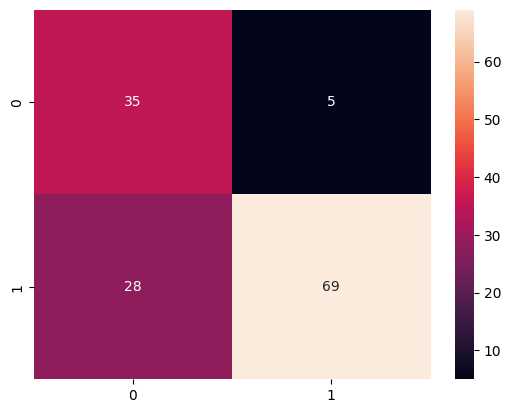

In [ ]:
# load the model from disk
filename = location + 'clin_GNB' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_gnb = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

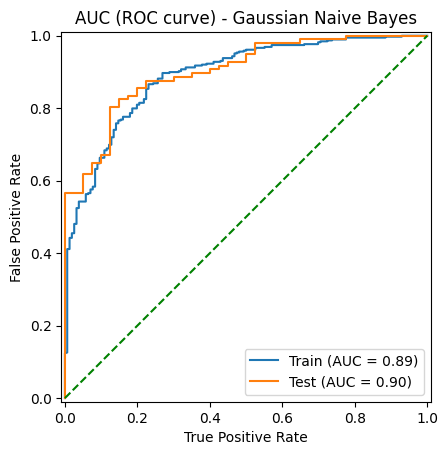

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    RocCurveDisplay.from_estimator(clf, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Gaussian Naive Bayes")
plt.show()

## **SVM**

---

In [ ]:
clf = SVC(probability=True, random_state=42)

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'gamma': ['scale', 'auto'],
      'shrinking': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      # 'decision_function_shape': ['ovo', 'ovr']
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 150
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'clin_SVM' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

SVC(C=50, class_weight={0: 0.66, 1: 0.33999999999999997}, gamma='auto',
    kernel='sigmoid', probability=True, random_state=42)
{'C': 50,
 'class_weight': {0: 0.66, 1: 0.33999999999999997},
 'gamma': 'auto',
 'kernel': 'sigmoid',
 'shrinking': True}

Saving model



AUC-ROC =  0.8506443298969071
AUC-PR =  0.9438964720739937
F1 score =  0.8994708994708994
Precision =  0.9239130434782609
Recall =  0.8762886597938144
              precision    recall  f1-score   support

           0       0.73      0.82      0.78        40
           1       0.92      0.88      0.90        97

    accuracy                           0.86       137
   macro avg       0.83      0.85      0.84       137
weighted avg       0.87      0.86      0.86       137



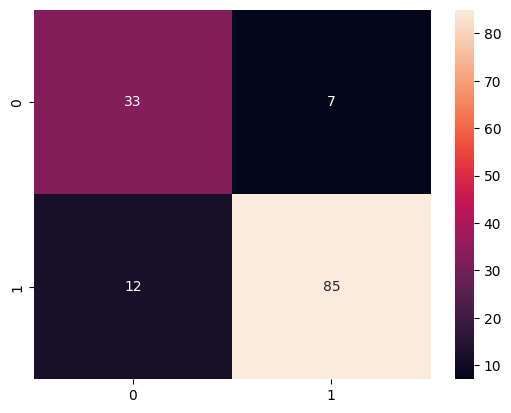

In [ ]:
# load the model from disk
filename = location + 'clin_SVM' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_svm = clf

y_pred = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
print("AUC-ROC = ", auc(fpr,tpr))
prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
print("AUC-PR = ", auc(rec, prec))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SVC(C=50, class_weight={0: 0.66, 1: 0.33999999999999997}, gamma='auto',
    kernel='sigmoid', probability=True, random_state=42)


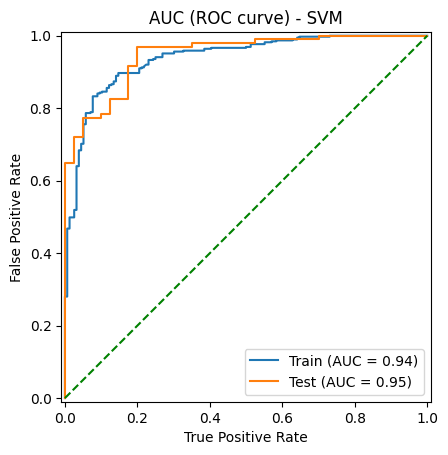

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  RocCurveDisplay.from_estimator(clf, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SVM")
plt.show()

## **Logistic Regression**

---

In [ ]:
clf = LogisticRegression()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'penalty': ['l1', 'l2', 'elasticnet'],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'multi_class': ['multinomial', 'ovr', 'auto'],
      'warm_start': [True, False],
      'l1_ratio': np.arange(0, 1.1, 0.1),
      'random_state': [81]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'clin_logReg' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1405 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
165 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File

LogisticRegression(C=1, class_weight={0: 0.65, 1: 0.35}, l1_ratio=0.5,
                   multi_class='ovr', penalty='l1', random_state=81,
                   solver='saga', warm_start=True)
{'C': 1,
 'class_weight': {0: 0.65, 1: 0.35},
 'l1_ratio': 0.5,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'random_state': 81,
 'solver': 'saga',
 'warm_start': True}

Saving model



AUC-ROC =  0.9417525773195876
AUC-PR =  0.975974809071066
F1 score =  0.9042553191489362
Precision =  0.9340659340659341
Recall =  0.8762886597938144
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        40
           1       0.93      0.88      0.90        97

    accuracy                           0.87       137
   macro avg       0.84      0.86      0.85       137
weighted avg       0.88      0.87      0.87       137



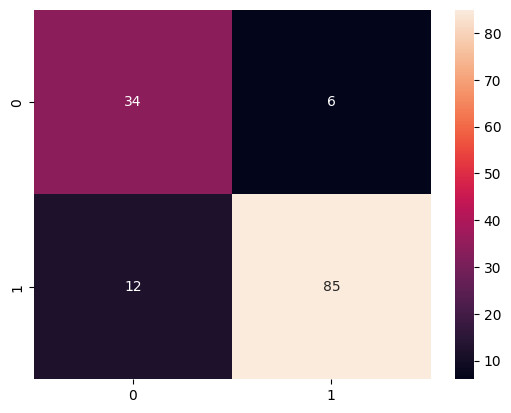

In [ ]:
# load the model from disk
filename = location + 'clin_logReg' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_logReg = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

LogisticRegression(C=1, class_weight={0: 0.65, 1: 0.35}, l1_ratio=0.5,
                   multi_class='ovr', penalty='l1', random_state=81,
                   solver='saga', warm_start=True)


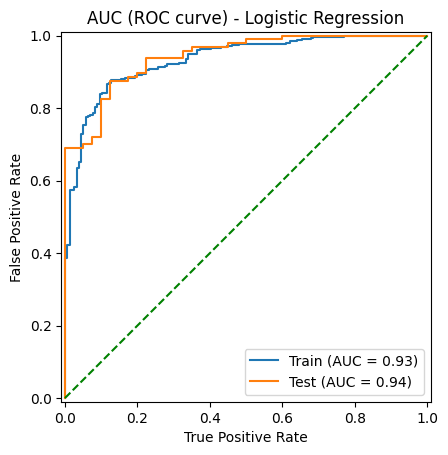

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  RocCurveDisplay.from_estimator(clf, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Logistic Regression")
plt.show()

## **LightGBM**

---

In [ ]:
clf = LGBMClassifier()

# # Parameters used by our current model
# print('Parameters initial\n')
# pprint(clf.get_params())

# Setting the range for class weights
weights = np.linspace(0.6, 0.99, 50)

# Specify parameters and distributions to sample from
hp = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'n_estimators': np.arange(50, 500, 50),
    'min_child_samples': np.arange(20, 200, 20),
    'subsample': np.linspace(0.5, 1, 10),
    'colsample_bytree': np.linspace(0.5, 1, 10),
    'reg_alpha': np.logspace(-4, 1, 20),
    'reg_lambda': np.logspace(-4, 1, 20),
    'class_weight': [{0: x, 1: 1.0 - x} for x in weights]
}

# # Print the parameter space
# pprint(hp)

# Run randomized search
print("\nStarting randomized search\n")
n_iter_search = 250
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                   param_distributions=hp,
                                   n_iter=n_iter_search,
                                   cv=StratifiedKFold(),
                                   verbose=2,
                                   scoring='roc_auc',
                                   return_train_score=True,
                                   n_jobs=n_jobs_val)

# Train the model using the training sets
random_search.fit(X, y)

# Display the best model and its parameters
pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

# Save the best estimator
clf = random_search.best_estimator_

clf.fit(X, y)

filename = location + 'clin_lgbm' + '.sav'
pickle.dump(clf, open(filename, 'wb'))



Starting randomized search

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[LightGBM] [Info] Number of positive: 389, number of negative: 156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 545, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430816 -> initscore=-0.278525
[LightGBM] [Info] Start training from score -0.278525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

AUC-ROC =  0.929639175257732
AUC-PR =  0.9689481160319512
F1 score =  0.91005291005291
Precision =  0.9347826086956522
Recall =  0.8865979381443299
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        40
           1       0.93      0.89      0.91        97

    accuracy                           0.88       137
   macro avg       0.85      0.87      0.86       137
weighted avg       0.88      0.88      0.88       137



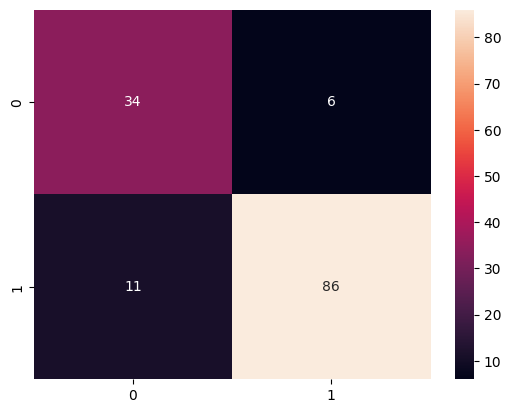

In [ ]:
# Load the model from disk
filename = location + 'clin_lgbm' + '.sav'
clf_lgbm = pickle.load(open(filename, 'rb'))

# Predictions and evaluation
y_pred = clf_lgbm.predict(X_test)
y_pred_proba = clf_lgbm.predict_proba(X_test)[:, 1]

# Display metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix - LightGBM")
plt.show()


LGBMClassifier(class_weight={0: 0.7671428571428571, 1: 0.23285714285714287},
               colsample_bytree=0.7222222222222222,
               learning_rate=0.11999999999999998, max_depth=10, n_estimators=50,
               num_leaves=120, reg_alpha=0.04281332398719392,
               reg_lambda=0.0003359818286283781, subsample=0.7222222222222222)


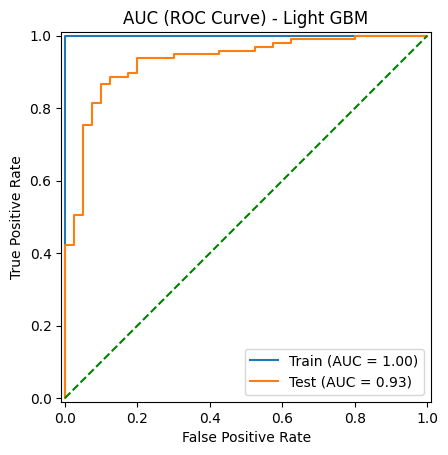

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_lgbm)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_lgbm, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Light GBM")
plt.show()

## **NN**

---

In [ ]:
clf = MLPClassifier(max_iter=200, random_state=42)

# Define the hyperparameter search space
param_dist = {
    'hidden_layer_sizes': [(np.random.randint(50, 200),) * np.random.randint(1, 4) for _ in range(10)],  # Randomly select layer sizes and depths
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': np.logspace(-5, 3, num=8),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': np.logspace(-4, 0, num=5),
    'batch_size': [32, 64, 128, 256],
    'early_stopping': [True],
    'n_iter_no_change': [5, 10, 15],
    'momentum': np.linspace(0.5, 0.95, num=5),
}

# Perform RandomizedSearchCV for hyperparameter tuning
print("\nStarting randomized search\n")
n_iter_search = 1500  # You can adjust this for a broader search
n_jobs_val = -1  # Use all available cores
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=StratifiedKFold(),
    verbose=5,
    scoring='roc_auc',
    return_train_score=True,
    n_jobs=n_jobs_val,
    random_state=42
)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

clf.fit(X,y)

# Save the best model to disk

print("\nSaving model\n")

filename = location + 'clin_mlp' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 751, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/l

MLPClassifier(activation='tanh', alpha=0.0019306977288832496, batch_size=32,
              early_stopping=True, hidden_layer_sizes=(188, 188, 188),
              momentum=0.95, n_iter_no_change=15, random_state=42)
{'activation': 'tanh',
 'alpha': 0.0019306977288832496,
 'batch_size': 32,
 'early_stopping': True,
 'hidden_layer_sizes': (188, 188, 188),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'momentum': 0.95,
 'n_iter_no_change': 15,
 'solver': 'adam'}

Saving model


Saving model



AUC-ROC =  0.9288659793814432
AUC-PR =  0.9688576381598913
F1 score =  0.8962264150943396
Precision =  0.8260869565217391
Recall =  0.979381443298969
              precision    recall  f1-score   support

           0       0.91      0.50      0.65        40
           1       0.83      0.98      0.90        97

    accuracy                           0.84       137
   macro avg       0.87      0.74      0.77       137
weighted avg       0.85      0.84      0.82       137



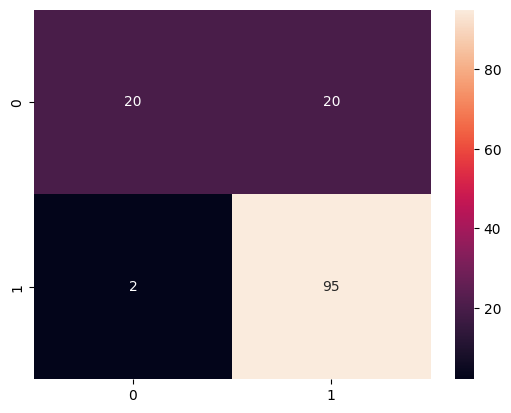

In [ ]:
# Load the model from disk
filename = location + 'clin_mlp' + '.sav'
clf_mlp = pickle.load(open(filename, 'rb'))

# Predictions and evaluation
y_pred = clf_mlp.predict(X_test)
y_pred_proba = clf_mlp.predict_proba(X_test)[:, 1]

# Display metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix - LightGBM")
plt.show()


MLPClassifier(activation='tanh', alpha=0.0019306977288832496, batch_size=32,
              early_stopping=True, hidden_layer_sizes=(188, 188, 188),
              momentum=0.95, n_iter_no_change=15, random_state=42)


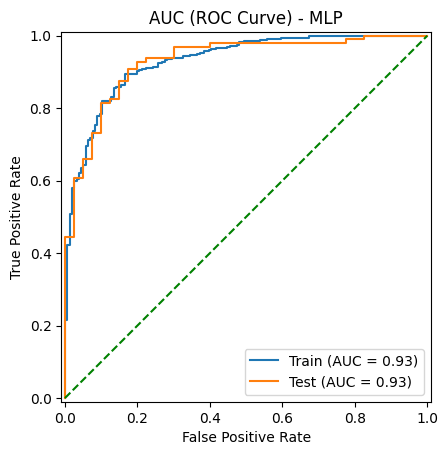

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_mlp)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_mlp, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - MLP")
plt.show()

# **Training the Ensemble Model**

---



In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.metrics import make_scorer

def custom_scorer(y_true, y_pred):
    f1_neg = f1_score(y_true, y_pred, pos_label=0)
    f1_pos = f1_score(y_true, y_pred, pos_label=1)
    return (f1_neg + f1_pos) / 2

custom_scorer = make_scorer(custom_scorer)

In [ ]:
clf_rf = pickle.load(open(location + 'clin_RF.sav', 'rb'))
clf_gnb = pickle.load(open(location + 'clin_GNB.sav', 'rb'))
clf_svm = pickle.load(open(location + 'clin_SVM.sav', 'rb'))
clf_logReg = pickle.load(open(location + 'clin_logReg.sav', 'rb'))
clf_lgbm = pickle.load(open(location + 'clin_lgbm.sav', 'rb'))
clf_mlp = pickle.load(open(location + 'clin_mlp.sav', 'rb'))

In [ ]:
  clf = VotingClassifier(
    estimators=[
        ('rf', clf_rf),
        ('gnb', clf_gnb),
        ('svm', clf_svm),
        ('logReg', clf_logReg),
        ('lgbm', clf_lgbm),
        ('mlp', clf_mlp)
    ],
    voting='soft'
)

hp = {
    'voting': ['hard', 'soft'],
    'flatten_transform': [True, False]
}

# Run randomized search
print("\nStarting randomized search for Ensemble\n")
n_iter_search = 100
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                   param_distributions=hp,
                                   n_iter=n_iter_search,
                                   cv=StratifiedKFold(),
                                   verbose=5,
                                   scoring=custom_scorer,
                                   return_train_score=True,
                                   n_jobs=n_jobs_val)

# Train the model
random_search.fit(X, y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving ensemble model\n")

clf = random_search.best_estimator_

# Train the model using the entire dataset
clf.fit(X, y)

# Save the model to disk
filename = location + 'clin_Ensemble.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search for Ensemble

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LightGBM] [Info] Number of positive: 389, number of negative: 156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 545, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430816 -> initscore=-0.278525
[LightGBM] [Info] Start training from score -0.278525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LightGBM] [Info] Number of positive: 389, number of negative: 156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 545, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430816 -> initscore=-0.278525
[LightGBM] [Info] Start training from score -0.278525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

AUC-ROC =  0.9391752577319588
AUC-PR =  0.9740394265520353
F1 score =  0.9214659685863874
Precision =  0.9361702127659575
Recall =  0.9072164948453608
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        40
           1       0.94      0.91      0.92        97

    accuracy                           0.89       137
   macro avg       0.86      0.88      0.87       137
weighted avg       0.89      0.89      0.89       137



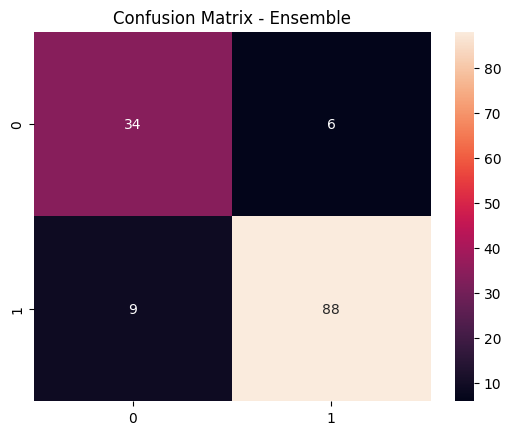

In [ ]:
# Load the model from disk
filename = location + 'clin_Ensemble.sav'
clf_ensemble = pickle.load(open(filename, 'rb'))

# Make predictions
y_pred = clf_ensemble.predict(X_test)
y_pred_proba = clf_ensemble.predict_proba(X_test)[:, 1]

# Print performance metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix - Ensemble")
plt.show()


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight={0: 0.8,
                                                                   1: 0.19999999999999996},
                                                     criterion='entropy',
                                                     max_depth=6,
                                                     max_features=7,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=350)),
                             ('gnb',
                              GaussianNB(var_smoothing=0.03393221771895328)),
                             ('svm',
                              SVC(C=50,
                                  class_weight={0: 0.66,
                                                1

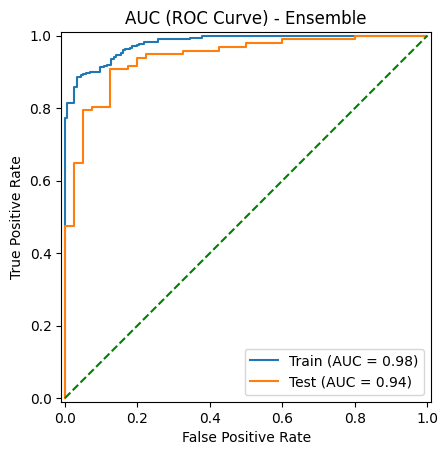

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_ensemble)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_ensemble, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Ensemble")
plt.show()

## **ROC Curve**

---

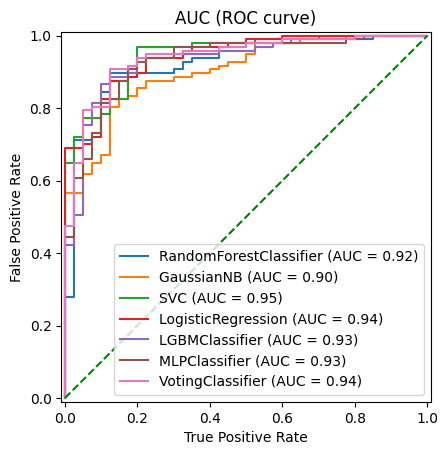

In [ ]:
ax = plt.gca()
classifiers = [clf_rf, clf_gnb, clf_svm, clf_logReg, clf_lgbm, clf_mlp, clf_ensemble]

for i in classifiers:
    RocCurveDisplay.from_estimator(i, X_test, y_test, ax=ax)
# plt.plot(fpr_test, tpr_test, label='ANN (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve)")
plt.show()

# **Checking random examples**

---



In [ ]:
index = 21

testing = (X_valid[index, :]).reshape(1,input_columns)
print(testing)
pred = model.predict(testing)
print("PREDICTION BY MODEL:", pred[0])
if (pred > 0.5):
  print("CLASS IS PD")
else:
  print("CLASS IS HC")
print("TRUE VALUE:", y_valid[index])

NameError: name 'X_valid' is not defined

In [ ]:
index = 63

testing = (X_valid[index, :]).reshape(1,input_columns)
print(testing)
pred = model.predict(testing)
print("PREDICTION BY MODEL:", pred[0])
if (pred > 0.5):
  print("CLASS IS PD")
else:
  print("CLASS IS HC")
print("TRUE VALUE:", y_valid[index])

[[0.33333333 0.         0.28571429 0.         0.88888889 0.33333333
  0.62068966 0.2654321  0.07407407 0.16347022 0.54807692 0.12037595
  0.27971311 0.         0.         0.         0.         0.
  0.69230769 0.13654618 0.16978777 0.11111111 0.08080808 0.02614379
  0.21367521 0.09259259 0.29925783 0.06395786 0.30769231]]
PREDICTION BY MODEL: [0.9239095]
CLASS IS PD
TRUE VALUE: [1.]


# **Checking Correlations**

---



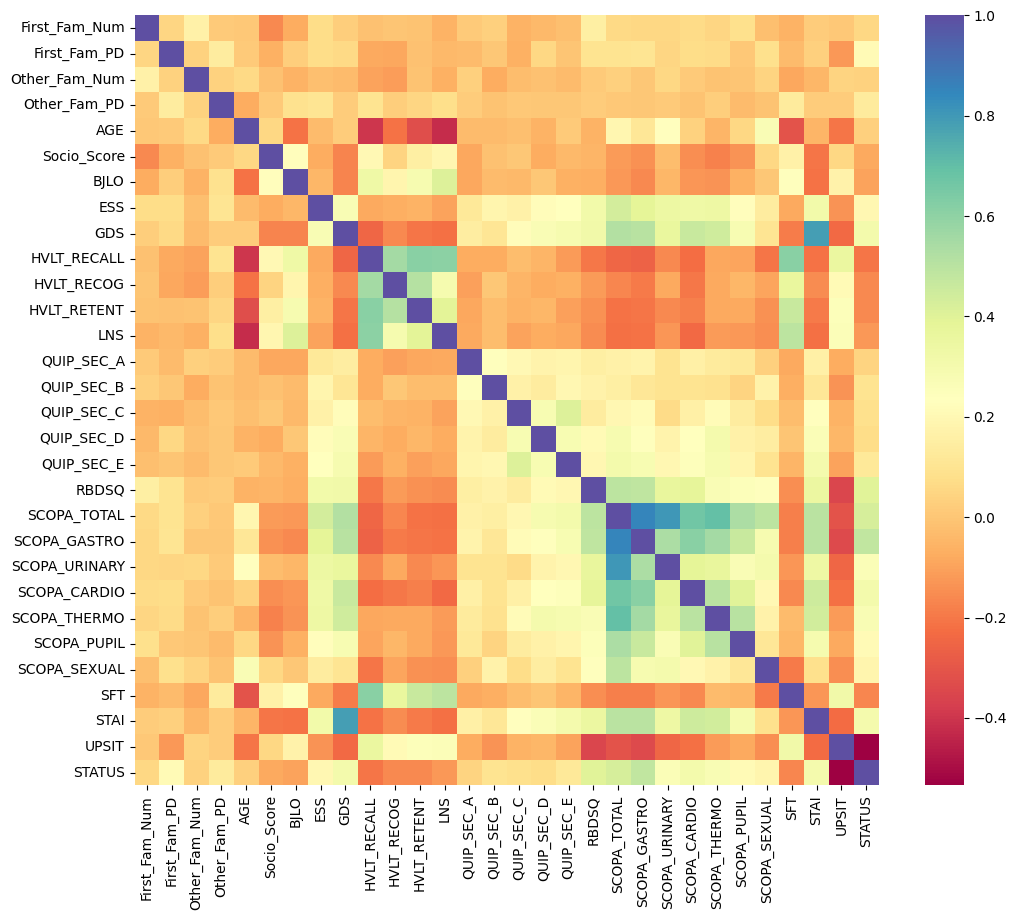

In [ ]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
y.values.flatten()

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,

In [ ]:
print("IMPORTANT FEATURES")
print()
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y.values.flatten())
    corr2, _ = pearsonr(X[:,i], y.values.flatten())
    if(abs(corr1) > 0.25 or abs(corr2) > 0.25 ):
        print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
print()

print("REDUNDANT FEATURES")
print()
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y.values.flatten())
    corr2, _ = pearsonr(X[:,i], y.values.flatten())
    if(abs(corr1)< 0.1 or abs(corr2) < 0.1 ):
        print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
print()

IMPORTANT FEATURES

GDS:		 Spearmans correlation: 0.389 Pearsons correlation: 0.319
RBDSQ:		 Spearmans correlation: 0.403 Pearsons correlation: 0.406
SCOPA_TOTAL:		 Spearmans correlation: 0.483 Pearsons correlation: 0.421
SCOPA_GASTRO:		 Spearmans correlation: 0.547 Pearsons correlation: 0.476
SCOPA_URINARY:		 Spearmans correlation: 0.306 Pearsons correlation: 0.278
SCOPA_CARDIO:		 Spearmans correlation: 0.365 Pearsons correlation: 0.290
SCOPA_THERMO:		 Spearmans correlation: 0.285 Pearsons correlation: 0.270
STAI:		 Spearmans correlation: 0.335 Pearsons correlation: 0.306
UPSIT:		 Spearmans correlation: 0.547 Pearsons correlation: 0.533

REDUNDANT FEATURES

First_Fam_Num:		 Spearmans correlation: 0.075 Pearsons correlation: 0.088
Other_Fam_Num:		 Spearmans correlation: 0.013 Pearsons correlation: 0.003
AGE:		 Spearmans correlation: 0.002 Pearsons correlation: 0.008
Socio_Score:		 Spearmans correlation: 0.070 Pearsons correlation: 0.076
LNS:		 Spearmans correlation: 0.095 Pearsons corr